### Adding a De-Noising Element to Watershed
[OpenCV Docs](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)

[Explanation](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)

In [1]:
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
# from mpl_toolkits import mplot3d

#### Import Image:

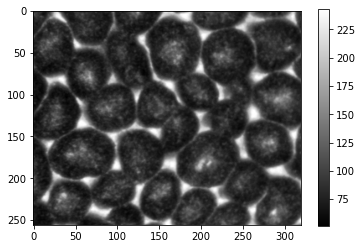

In [2]:
source_dir = "/Users/johnmays/Documents/Wirth Lab/convection-cell-research/data/LCB6mil90deg0_frames"
os.chdir(source_dir)
frame1 = cv.imread('frame1.png')
height, width, depth = np.shape(frame1)
frame1_downsized = cv.resize(frame1, (int(width/2), int(height/2)), cv.INTER_AREA) # downsize
frame1_downsized_gray = cv.cvtColor(frame1_downsized,cv.COLOR_BGR2GRAY)
frame1_cropped = frame1_downsized_gray[0:256,0:320]
plt.imshow(frame1_cropped, cmap='binary_r')
plt.colorbar();

#### Step 1: Threshold in Python:

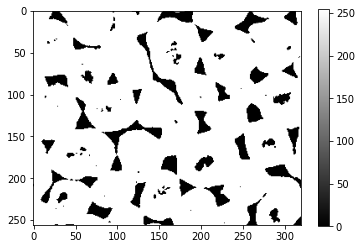

In [3]:
ret, thresh = cv.threshold(frame1_cropped,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh, cmap='binary_r')
plt.colorbar();

#### Step 2: De-Noise in Python w/ Custom Functions

Writing a method to generate a list of black areas in an image

In [4]:
def getbackgroundareas(image):
    # takes in a monochrome, binary image matrix
    areas = []
    area_locations = []
    visited = np.zeros(np.shape(image), dtype=bool)
    for row in range(np.shape(image)[0]):
        for col in range(np.shape(image)[1]):
            if visited[row][col] == False:
                area_coords = expandarea((row, col), image, visited)
                if area_coords != []:
                    area_locations.append(area_coords)
                    areas.append(len(area_coords))
    return areas, area_locations

In [5]:
def expandarea(coord, image, visited):
    if coord[0] < 0 or coord[0] >= np.shape(image)[0]:
        return []
    if coord[1] < 0 or coord[1] >= np.shape(image)[1]:
        return []
    if visited[coord[0]][coord[1]] == False:
        visited[coord[0]][coord[1]] = True
        current_pixel = image[coord[0]][coord[1]]
        if current_pixel == 0:
            return [coord] \
                + expandarea((coord[0]+1, coord[1]), image, visited) \
                    + expandarea((coord[0]-1, coord[1]), image, visited) \
                        + expandarea((coord[0], coord[1]+1), image, visited) \
                            + expandarea((coord[0], coord[1]-1), image, visited)
        else:
            return []
    else:
        return []

##### Testing:

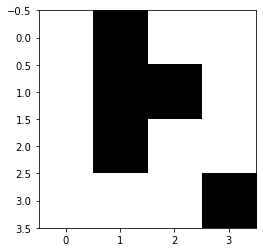

In [6]:
test_img = np.array([
    [255,0,255,255],
    [255,0,0,255],
    [255,0,255,255],
    [255,255,255,0],
])
plt.imshow(test_img, cmap='Greys_r');

In [7]:
def colorareas(image, thresh):
    # takes in a monochrome, thresholded image
    image_3channel = np.stack((image,image,image), axis=-1)
    areas, area_locations = getbackgroundareas(image)
    for i in range(len(areas)):
        area = areas[i]
        if area < thresh:
            for coord in area_locations[i]:
                image_3channel[coord[0]][coord[1]] = [255,0,0]
    return image_3channel

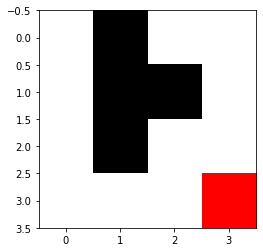

In [8]:
plt.imshow(colorareas(test_img, 2));

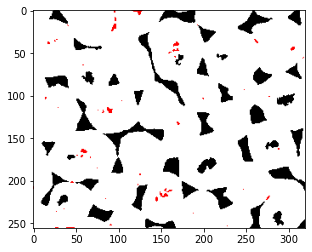

In [9]:
plt.imshow(colorareas(thresh, 40));

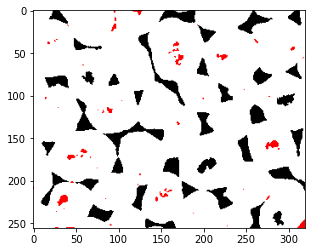

In [10]:
plt.imshow(colorareas(thresh, 110));

In [11]:
def purgesmallareas(image, thresh):
    # takes in a monochrome, thresholded image
    final_image = np.copy(image)
    areas, area_locations = getbackgroundareas(image)
    for i in range(len(areas)):
        area = areas[i]
        if area < thresh:
            for coord in area_locations[i]:
                final_image[coord[0]][coord[1]] = 255
    return final_image

In [12]:
frame1_cropped_denoised = purgesmallareas(thresh, 110)

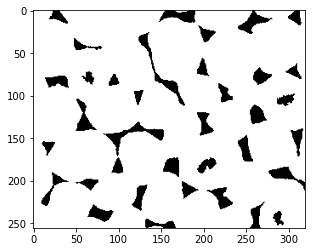

In [13]:
plt.imshow(frame1_cropped_denoised, cmap='Greys_r');

In [14]:
def invert(image):
    newimage = np.copy(image)
    for row in range(np.shape(image)[0]):
        for col in range(np.shape(image)[1]):
            newimage[row,col] = 255 - newimage[row,col]
    return newimage

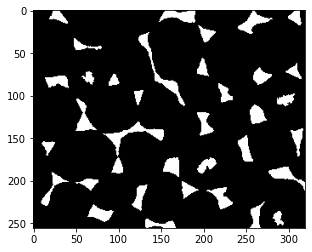

In [15]:
frame1_cropped_denoised_inverted = invert(frame1_cropped_denoised)
plt.imshow(frame1_cropped_denoised_inverted, cmap='binary_r');

In [16]:

frame1_cropped_denoised_inverted_3channel = np.stack((frame1_cropped_denoised_inverted, frame1_cropped_denoised_inverted, frame1_cropped_denoised_inverted), axis=-1)
plt.imsave("frame1_crop_imagej.png", frame1_cropped_denoised_inverted_3channel)

#### Step 3: Watershed in ImageJ

In [17]:
watershed = cv.imread('watershed_screenshot.png')


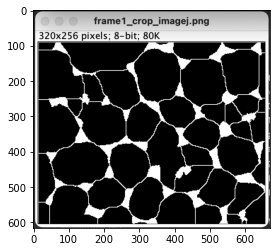

In [18]:
plt.imshow(watershed);

- Image -> Type -> 8bit
- Process -> Binary -> Watershed
- Analyze -> Analyze Particles

#### Testing New Irregularity Measurement:

In [19]:
def borderirregularity(P_set):
    # P_set is set of pixels that form an area
    A = len(P_set) # area
    B_set = [] # B_set is set of pixels that could be considered as belonging to the border of the area
    N_set = []
    for pixel in P_set:
        if (pixel[0], pixel[1]+1) in P_set and (pixel[0], pixel[1]-1) in P_set and \
            (pixel[0]+1, pixel[1]) in P_set and (pixel[0]-1, pixel[1]) in P_set:
            continue
        else:
            B_set.append(pixel)
            neighbors = 0
            if (pixel[0], pixel[1]) in P_set:
                neighbors += 1
            if (pixel[0], pixel[1]) in P_set:
                neighbors += 1
            if (pixel[0], pixel[1]) in P_set:
                neighbors += 1
            #### STOPPED HERE
            N_set.append(neighbors)
    N = np.sum(neighbors)
    B = len(B_set)
    return N/B